In [6]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image
import torchvision.transforms as transforms
import os

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading Data

In [10]:
def load_data(batch_size=64):
  # Compose allows us to have multiple transformations to occur
  # and resize all images to 224x224
  transform_it = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

  # Save the paths of each of the different types of data that are located in my drive 
  train_path = '/content/gdrive/MyDrive/Primary Models/sample_large/train'
  val_path = '/content/gdrive/MyDrive/Primary Models/sample_large/val'
  test_path = '/content/gdrive/MyDrive/Primary Models/sample_large/test'

  # Load all of the data from my google drive
  train_data = torchvision.datasets.ImageFolder(train_path, transform=transform_it)
  val_data = torchvision.datasets.ImageFolder(val_path, transform=transform_it)
  test_data = torchvision.datasets.ImageFolder(test_path, transform=transform_it)

  print("Training Examples:", len(train_data))
  print("Validation Examples:", len(val_data))
  print("Test Examples:", len(test_data))

  return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = load_data()

In [13]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

In [15]:
# Load all of the data such as training, validation and test
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, num_workers=1, shuffle=True)

# Create a function to save all the features into the folders 
def load_features(loader, new_main_dir, folder):
  classes = ['Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'COVID-19']

  n = 0
  for img, label in loader:
    # Get the features of each image and transform to a tensor 
    feature = alexnet.features(img)
    feature_tensor = torch.from_numpy(feature.detach().numpy())

    # Save those features into folder 
    feature_dir = new_main_dir + '/' + str(folder) + '/' + str(classes[label])
    if not os.path.isdir(feature_dir):
      os.mkdir(feature_dir)
    torch.save(feature_tensor.squeeze(0), feature_dir + '/' + str(n) + '.tensor')

    n+=1

  print("Features done for ", folder)

In [ ]:
# load_features(train_loader, '/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet', 'Train')
# load_features(val_loader,'/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet','Validation')
# load_features(test_loader,'/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet','Test')

Features done for  Train
Features done for  Validation
Features done for  Test


In [60]:
# Load features from folder

# Retrieve dataset
features_train = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Train', loader=torch.load, extensions=('.tensor'))
features_val = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Validation', loader=torch.load, extensions=('.tensor'))
features_test = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Test', loader=torch.load, extensions=('.tensor'))

# Prepare loader
features_train_loader = torch.utils.data.DataLoader(features_train, batch_size=64, shuffle=True)
features_val_loader = torch.utils.data.DataLoader(features_val, batch_size=64, shuffle=True)
features_test_loader = torch.utils.data.DataLoader(features_test, batch_size=64, shuffle=True)

### Training

In [61]:
# For the model checkpoints 
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [63]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [64]:
def train(model, train_loader, val_loader, batch_size=64, learning_rate=0.001, num_epochs=20):
    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
          
          
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              #print("GPU is Available")
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            #out, aux_outputs = model(imgs)
            #loss1 = criterion(out, labels)
            #loss2 = criterion(aux_outputs, labels)
            #loss = loss1 + 0.4 * loss2
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
            n += 1

        # Print the accuracies of validation and training for each epoch to observe how it changes over time 
        print("epoch number: ", epoch+1, "Training accuracy: ",train_acc[epoch], "Validation accuracy: ", val_acc[epoch])
        # Save the current model (checkpoint) to a file
        model_path = get_model_name("inceptionv3", batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)      

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
class AlexNet_Classifier(nn.Module):
    def __init__(self):
        super(AlexNet_Classifier, self).__init__()
        self.name = "AlexNet"
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 9)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CUDA is available!  Training on GPU ...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14


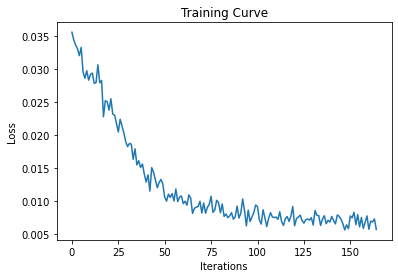

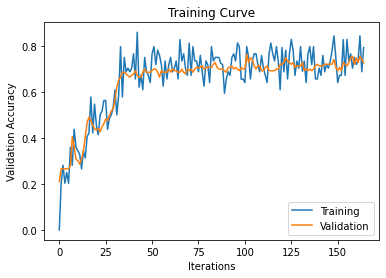

Final Training Accuracy: 0.7473841554559043
Final Validation Accuracy: 0.7272727272727273


In [ ]:
AlexNet_Model = AlexNet_Classifier()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  AlexNet_Model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
alex_train(model=AlexNet_Model, batch_size=64, learning_rate=0.001, num_epochs=15, train_loader=features_train_loader, val_loader=features_val_loader)

In [ ]:
class Xray_Classifier_MODEL2(nn.Module):
      def __init__(self):
          self.name = "Xray_Classifier_MODEL2"
          super(Xray_Classifier_MODEL2, self).__init__()
          self.conv1 = nn.Conv2d(256, 512, 3) #in_channel=3, out_channel=5, kernel_size=5
          #self.pool = nn.MaxPool2d(2, 2) #kernel_size=2, stride=2 
          #self.conv2 = nn.Conv2d(512, 10, 2) #in_channel=5, out_channel=10, kernel_size=5
          self.fc1 = nn.Linear(512*4*4, 80) #in_features=10*53*53, out_features=80
          self.fc2 = nn.Linear(80, 30) #in_features=80, out_features=30
          self.fc3 = nn.Linear(30, 4) #in_features=30, out_features=4

      def forward(self, x):
          #x = self.pool(F.relu(self.conv1(x))) #apply pooling to 1st convolution layer
          #x = self.pool(F.relu(self.conv2(x))) #apply pooling to 2nd convolution layer
          x = F.relu(self.conv1(x))
          #x = F.relu(self.conv2(x))
          x = x.view(-1, 512*4*4)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

CUDA is available!  Training on GPU ...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19


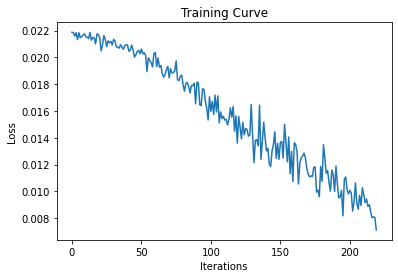

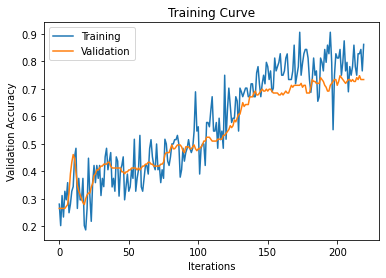

Final Training Accuracy: 0.8056801195814649
Final Validation Accuracy: 0.7342657342657343


In [ ]:
AlexNet_CNN_Model = Xray_Classifier_MODEL2()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  AlexNet_CNN_Model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
alex_train(model=AlexNet_CNN_Model, batch_size=64, learning_rate=0.001, num_epochs=20, train_loader=features_train_loader, val_loader=features_val_loader)

CUDA is available!  Training on GPU ...
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19


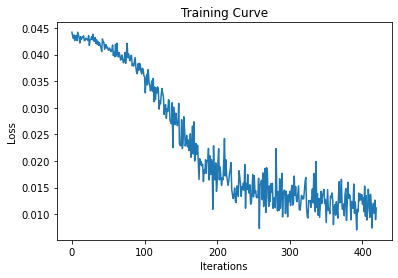

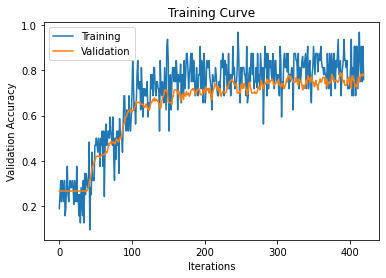

Final Training Accuracy: 0.8355754857997011
Final Validation Accuracy: 0.7832167832167832


In [ ]:
# Prepare loader
features_train_loader = torch.utils.data.DataLoader(features_train, batch_size=32, shuffle=True)
features_val_loader = torch.utils.data.DataLoader(features_val, batch_size=32, shuffle=True)
features_test_loader = torch.utils.data.DataLoader(features_test, batch_size=32, shuffle=True)

AlexNet_CNN_Model_2 = Xray_Classifier_MODEL2()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  AlexNet_CNN_Model_2.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
alex_train(model=AlexNet_CNN_Model_2, batch_size=32, learning_rate=0.001, num_epochs=20, train_loader=features_train_loader, val_loader=features_val_loader)

In [43]:
class AlexClassifier(nn.Module):
      def __init__(self):
          self.name = "AlexClassifier"
          super(AlexClassifier, self).__init__()
          self.conv1 = nn.Conv2d(256, 100, 2) #in_channels, out_chanels, kernel_size 
          self.conv2 = nn.Conv2d(100, 10, 2) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(10*4*4, 30)
          self.fc2 = nn.Linear(30, 4)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = F.relu(self.conv2(x))
          x = x.view(-1, 10*4*4)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

In [65]:
bs = 64
# Prepare loader
features_train_loader = torch.utils.data.DataLoader(features_train, batch_size=bs, shuffle=True)
features_val_loader = torch.utils.data.DataLoader(features_val, batch_size=bs, shuffle=True)
features_test_loader = torch.utils.data.DataLoader(features_test, batch_size=bs, shuffle=True)

AlexNet_Model = AlexClassifier()

In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  AlexNet_Model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(AlexNet_Model, features_train_loader, features_val_loader, batch_size=bs, learning_rate=0.001, num_epochs=40)

In [68]:
class Xray_Classifier_CNN(nn.Module):
      def __init__(self):
          self.name = "Xray_Classifier_CNN"
          super(Xray_Classifier_CNN, self).__init__()
          self.conv1 = nn.Conv2d(256, 512, 3)
          self.fc1 = nn.Linear(512*4*4, 80)
          self.fc2 = nn.Linear(80, 30)
          self.fc3 = nn.Linear(30, 4)

      def forward(self, x):
          x = F.relu(self.conv1(x))
          x = x.view(-1, 512*4*4)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [71]:
bs = 32
# Load features from folder

# Retrieve dataset
features_train = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Train', loader=torch.load, extensions=('.tensor'))
features_val = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Validation', loader=torch.load, extensions=('.tensor'))
features_test = torchvision.datasets.DatasetFolder('/content/gdrive/MyDrive/Primary Models/transfer_learning/AlexNet/Test', loader=torch.load, extensions=('.tensor'))

# Prepare loader
features_train_loader = torch.utils.data.DataLoader(features_train, batch_size=bs, shuffle=True)
features_val_loader = torch.utils.data.DataLoader(features_val, batch_size=bs, shuffle=True)
features_test_loader = torch.utils.data.DataLoader(features_test, batch_size=bs, shuffle=True)

AlexNet_CNN_Model = Xray_Classifier_CNN()

CUDA is available!  Training on GPU ...
epoch number:  1 Training accuracy:  0.2556053811659193 Validation accuracy:  0.2517482517482518
epoch number:  2 Training accuracy:  0.26307922272047835 Validation accuracy:  0.26573426573426573
epoch number:  3 Training accuracy:  0.26307922272047835 Validation accuracy:  0.26573426573426573
epoch number:  4 Training accuracy:  0.26307922272047835 Validation accuracy:  0.26573426573426573
epoch number:  5 Training accuracy:  0.3542600896860987 Validation accuracy:  0.32867132867132864
epoch number:  6 Training accuracy:  0.476831091180867 Validation accuracy:  0.4755244755244755
epoch number:  7 Training accuracy:  0.5097159940209267 Validation accuracy:  0.5104895104895105
epoch number:  8 Training accuracy:  0.6502242152466368 Validation accuracy:  0.6013986013986014
epoch number:  9 Training accuracy:  0.4678624813153961 Validation accuracy:  0.4195804195804196
epoch number:  10 Training accuracy:  0.5082212257100149 Validation accuracy:  0.

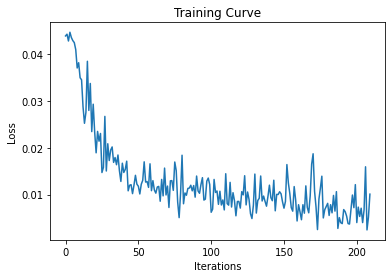

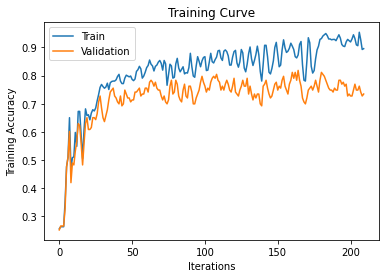

Final Training Accuracy: 0.8953662182361734
Final Validation Accuracy: 0.7342657342657343


In [72]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  AlexNet_CNN_Model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
train(AlexNet_CNN_Model, features_train_loader, features_val_loader, batch_size=bs, learning_rate=0.001, num_epochs=10)